# Numerically testing the detector position

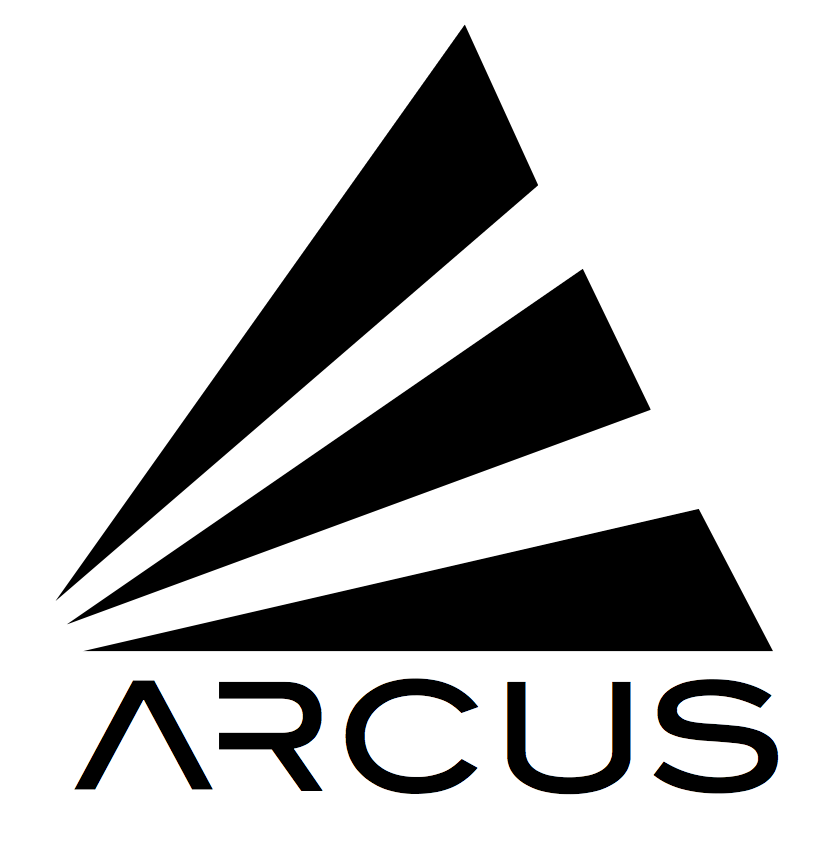

### Revision status
Last revision in version control:

- Author: Hans Moritz Guenther <hgunther@mit.edu>
- commit bd6c6feb055e5cbff9942dcd9a49462218cffb65
- Date:   Tue Nov 14 23:43:35 2017 -0500

**The version shown here is modified compared to the last commited revision.**

            

This document is git version controlled. The repository is available at https://github.com/hamogu/arcus.
See git commit log for full revision history.

Code was last run with:

- MARXS ray-trace code version 1.2.dev643 (commit hash: c7a3e480d6 from 2018-06-26)
- ARCUS python code version 0.0.dev153 (commit hash: 3d289c95aa from 2018-02-07)
- ARCUS CALDB version hash: 5590a73 (commited on 2018-05-15 )


In [1]:
from nbtemplate import display_header, display_codetoggle, get_path
display_header('Testoffocus.ipynb')

## Goal

In this show memo, I want to test that the analytically derived detector position is indeed correct. From theory, we know that the detectors should be placed tagential to the Rowland circle and Arcus follows this layout. Here, we want derive the ideal detector position numerically to confirm that the Rowland geometry is in fact valid; one might think that non-ideal effect such as the finite size of the flat facets which do not follow the Rowland torus exactly might lead to a slightly distorted focal surface.

## Appoach

Let us follow the rays from the mirror, though the gratings on its way
to the CCDs. After leaving the CAT gratings, the rays are wide both in
dispersion and in cross-dispersion direction. Travelling down in the
direction of the focal plane, the beam then gets narrower in both
directions. Eventually, it reaches a point where it is the narrowest in
dispersion direction, but still relatively wide in cross-dispersion
direction (this is the "spectroscopic focus"), the PSF is elongated. Beyond this point, the
beam widens again in dispersion direction, but continues to narrow in
cross-dispersion direction, the PSF becomes rounder until it reaches
(approximately) a circle ("imaging focus"). This is the point where the total
PSF size is smallest. The beam continues to narrow in cross-dispersion
direction, and widen in dispersion direction until you hit the minimum
in cross-disperion direction ("cross-dispersion focus"), the PSF is elongated again, but
with the long axis in dispersion direction now. Beyond that, the beam
get wider in both directions again. (Note that the order of these three foci can be reversed for Rowland tori where $R$ is smaller than $r$.)

We take a grid of simulations for different wavelength points then iterate over all channels and all orders which happen to have > 20 rays in that channel and order for that specific wavelength. In total, that gives me > 2000 sets of rays for which I can numerically find the spectroscopic focus, the imaging focus and the cross-dispersion focus (I am not awar of any practical use for this point, but it is easy to find anyway).

In [2]:
import os
import glob
# get on-axis rays
raylist = glob.glob(os.path.join(get_path('forsixte'), '*_0_0.fits'))

Reading config file with path definitions: ['../site.cfg']


In [3]:
import numpy as np
from astropy.table import Table
from marxs.math.utils import e2h
from marxs.analysis.analysis import find_best_detector_position, mean_width_2d
from arcus.arcus import xyz2zxy

In [4]:
def get_all_foci(photons):
    out = []
    for chan in range(3):
        for o in range(-12, 1):
            tn = tab[(tab['order'] == o) & (tab['channel'] == chan)]
            if len(tn) > 20:
                out.append([chan, o,
                            find_best_detector_position(tn, orientation=xyz2zxy[:3, :3]).x,
                            tn['det_x'].mean(),
                            find_best_detector_position(tn, orientation=xyz2zxy[:3, :3], 
                                objective_func=mean_width_2d,
                                objective_func_args={}).x,
                            tn['det_x'].mean(),
                            find_best_detector_position(tn, orientation=xyz2zxy[:3, :3], 
                                objective_func_args={'colname': 'det_y'}).x,
                            tn['det_x'].mean()])
    return out

In [5]:
allfoci = []
for filename in raylist:
    tab = Table.read(filename, hdu=1)
    tab['pos'] = e2h(tab['POS'], 1)
    tab['dir'] = e2h(tab['DIR'], 0)
    allfoci.append(np.array(get_all_foci(tab)))

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/marxs-1.2.dev643-py2.7.egg/marxs/analysis/analysis.py:82: OptimizeWarning: Unknown solver options: disp
  **kwargs)


In [6]:
arr = np.vstack(allfoci)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
from arcus.arcus import DetCamera, defaultconf
det = DetCamera(conf=defaultconf)

## Results

The plot below shows the position of best focus determined for all wavelengths, channels and orders. Together, these points map out the focus surface well. Overplotted are the Arcus CCD positions with colored lines. They are easy to miss, because they follow the spectroscopic focus almost exactly.

Reading config file with path definitions: ['../site.cfg']
Reading config file with path definitions: ['../site.cfg']


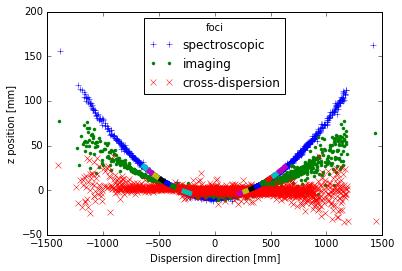

In [9]:
plt.plot(arr[:, 3], arr[:, 2], '+', label='spectroscopic')
plt.plot(arr[:, 5], arr[:, 4], '.', label='imaging')
plt.plot(arr[:, 7], arr[:, 6], 'x', label='cross-dispersion')
plt.xlabel('Dispersion direction [mm]')
plt.ylabel('z position [mm]')
for ccd in det.elements:
    center = ccd.geometry('center')[[0, 2]]
    vec = ccd.geometry('v_y')[[0, 2]]
    edges = np.stack([center - vec, center + vec])
    plt.plot(edges[:, 0], edges[:, 1], label='__no_legend__', lw=5)

plt.legend(loc='upper center', title='foci')
plt.savefig(os.path.join(get_path("figures"), 'Testfocus.png'), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(get_path("figures"), 'Testfocus.pdf'), bbox_inches='tight', dpi=300)

Reading config file with path definitions: ['../site.cfg']
Reading config file with path definitions: ['../site.cfg']


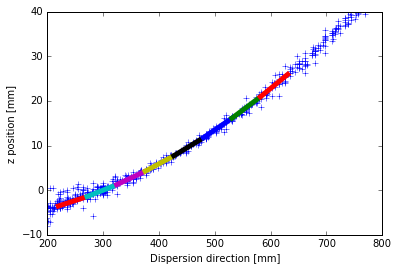

In [10]:
plt.plot(arr[:, 3], arr[:, 2], '+', label='spectroscopic')
plt.xlabel('Dispersion direction [mm]')
plt.ylabel('z position [mm]')
for ccd in det.elements:
    center = ccd.geometry('center')[[0, 2]]
    vec = ccd.geometry('v_y')[[0, 2]]
    edges = np.stack([center - vec, center + vec])
    plt.plot(edges[:, 0], edges[:, 1], label='__no_legend__', lw=5)
    
plt.xlim(200, 800)
plt.ylim(-10, 40)
plt.savefig(os.path.join(get_path("figures"), 'Testfocuszoom.png'), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(get_path("figures"), 'Testfocuszoom.pdf'), bbox_inches='tight', dpi=300)

This second plot zooms in on one camera with eight CCDs. Looking this closely, one can see that the CCDs match the position of the numerically determined focus values better than 1 mm, which is the acceptable distance from the ideal focus before defocussing degrades the spectral resolving power significantly. A fit by-eye indicates that the numerically determined focus is about 0.2 mm below the CCD position. This deviation is more than expected from the scatter. This difference is smaller than the focus tolerance determined from our [tolerancing study](http://space.mit.edu/home/guenther/ARCUS/Tolerances.html). More investigation can be done later, but a likely cause of the 0.2 mm distance is the finite size of the CAT grating facets. In Arcus, we place he center point of a CAT grating on the Rowland torus and then apply the correct rotation and blaze angle. While the CAT grating center will always be exactly on the Rowland torus, the edges will typically be located a little "above" the Rowland torus. This means that, on average, the rays get diffracted at a slightly larger distance from the focal point then they should be. This is equivalent to using a slightly larger radius for the Rowland circle, and a slightly larger radius means that the CCDs need to be placed a little further away from the CAT gratings, consistent with the numerical best focus being about 0.2 mm lower than the CCDs on the Rowland circle. 

In [11]:
display_codetoggle()